## Conditional Edges: Defining Nodes and a Routing Function
LangGraph example with conditional routing.
Implements a question-answer loop using an OpenAI chat mode

### Set the OpenAI API Key as an Environment Variable

In [1]:
%load_ext dotenv
%dotenv
%load_ext mypy_ipython

### Import Relevant Classes and Functions

In [2]:
from langgraph.graph import START, END, StateGraph
from typing_extensions import TypedDict
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, BaseMessage
from collections.abc import Sequence
from typing import Literal

### Define the State

In [3]:
class State(TypedDict):
    messages: Sequence[BaseMessage]

### Define the Nodes

In [4]:
chat = ChatOpenAI(model = "gpt-4o", 
                  seed = 365, 
                  temperature = 0, 
                  max_completion_tokens = 100)

In [5]:
def ask_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_question:")
    
    print("What is your question?")
    
    return State(messages = [HumanMessage(input())])

In [6]:
ask_question(State(messages = []))


-------> ENTERING ask_question:
What is your question?


 Could you tell me a grook by Piet Hein?


{'messages': [HumanMessage(content='Could you tell me a grook by Piet Hein?', additional_kwargs={}, response_metadata={})]}

In [7]:
def chatbot(state: State) -> State:
    
    print(f"\n-------> ENTERING chatbot:")
    
    response = chat.invoke(state["messages"])
    response.pretty_print()
    
    return State(messages = [response])

In [8]:
def ask_another_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_another_question:")
    
    print("Would you like to ask one more question (yes/no)?")
    
    return State(messages = [HumanMessage(input())])

In [9]:
ask_another_question(State(messages = []))


-------> ENTERING ask_another_question:
Would you like to ask one more question (yes/no)?


 yes


{'messages': [HumanMessage(content='yes', additional_kwargs={}, response_metadata={})]}

### Define the Routing Function

In [15]:
# There are two valid approaches to implement conditional routing in LangGraph:
# 1. Using a path_map when adding conditional edges to explicitly map outcomes to nodes.
# 2. Using a routing function that returns a Literal value representing the next node,
#    allowing LangGraph to infer the conditional edges automatically.
#1 
    # graph.add_conditional_edges(
    #     source="ask_another_question",
    #     path=routing_function,
    #     path_map={
    #         True: "ask_question",
    #         False: __end__
    #     }
    # )

# def routing_function(state: State) -> str:
        
#         if state["messages"].content == "yes":
#             return "ask_question"
#         else:
#             return "__end__"
#2
def routing_function(state: State) -> Literal["ask_question", "__end__"]:
    
    if state["messages"][0].content == "yes":
        return "ask_question"
    else:
        return "__end__"

### Define the Graph

In [16]:
graph = StateGraph(State)

In [17]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function)
# graph.add_conditional_edges(
#     source="ask_another_question",
#     path=routing_function,
#     path_map={
#         True: "ask_question",
#         False: "__end__"
#     }
# )

In [18]:
graph_compiled = graph.compile()

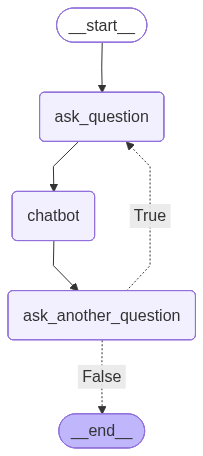

In [14]:
graph_compiled #1

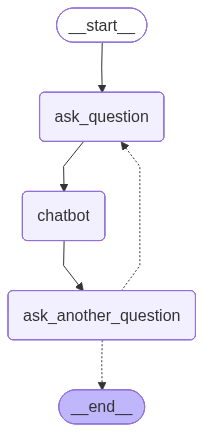

In [19]:
graph_compiled #2

In [20]:
print(graph_compiled.get_graph().draw_ascii())

          +-----------+       
          | __start__ |       
          +-----------+       
                 *            
                 *            
                 *            
         +--------------+     
         | ask_question |     
         +--------------+     
          ***         ..      
         *              ..    
       **                 ..  
+---------+                 . 
| chatbot |               ..  
+---------+             ..    
          ***         ..      
             *      ..        
              **   .          
     +----------------------+ 
     | ask_another_question | 
     +----------------------+ 
                 .            
                 .            
                 .            
            +---------+       
            | __end__ |       
            +---------+       


### Test the Graph

In [21]:
graph_compiled.invoke(State(messages = []))


-------> ENTERING ask_question:
What is your question?


 Could you tell me a grook by Piet Hein?



-------> ENTERING chatbot:
================================== Ai Message ==================================

Certainly! Here is one of Piet Hein's well-known grooks:

```
Losing One Glove

Losing one glove
is certainly painful,
but nothing
compared to the pain
of losing one,
throwing away the other,
and finding
the first one again.
```

Piet Hein's grooks are known for their brevity and wit, often encapsulating profound insights in just a few lines.

-------> ENTERING ask_another_question:
Would you like to ask one more question (yes/no)?


 yes



-------> ENTERING ask_question:
What is your question?


 Where was the poet born?



-------> ENTERING chatbot:
================================== Ai Message ==================================

I'm sorry, but I need more information to answer your question. Could you please specify which poet you are referring to?

-------> ENTERING ask_another_question:
Would you like to ask one more question (yes/no)?


 no


{'messages': [HumanMessage(content='no', additional_kwargs={}, response_metadata={})]}